Time series prediction task

In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from statsmodels.datasets import sunspots
import time
from tqdm import tqdm
import sys
import os
sys.path.append(os.path.abspath('..'))
from kans import BSplineKAN, FourierKAN, GaussianKAN, JacobiKAN, RationalKAN, TaylorKAN, WaveletKAN, BernsteinKAN, MLP

torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

if os.path.exists('model') is False:
	os.makedirs('model')

cpu


In [2]:
def create_series_dataset(series, history_size):
    X, Y = [], []
    for i in range(len(series) - history_size):
        X.append(series[i:i+history_size])
        Y.append(series[i+history_size])
    return torch.stack(X), torch.stack(Y).unsqueeze(1)

def test(model, test_input, test_data, criterion):
	model.eval()
	predict_data = torch.empty(len(test_data))
	with torch.no_grad():
		for i in range(len(test_data)):
			output = model(test_input)
			predict_data[i] = output
			test_input = torch.cat((test_input[:,1:], output), dim=1)
		loss = criterion(predict_data, test_data)
	return loss.item(), predict_data

def plot_fitting_and_predict(model, model_name, series, X_train, test_input, test_data, criterion, series_mean, series_std):
	train_predict = model(X_train).detach()
	test_loss, test_predict = test(model, test_input, test_data, criterion)
	train_predict = train_predict * series_std + series_mean
	test_predict = test_predict * series_std + series_mean
	series = series * series_std + series_mean
	
	plt.figure(figsize=(8,6))
	plt.plot(series, label='True Data', color='b', linestyle='dashed', alpha=0.5)
	plt.plot(range(test_input.size(1), len(train_predict)+test_input.size(1)), train_predict, label='Fitting Data', color='r')
	plt.plot(range(len(train_predict)+test_input.size(1), len(series)), test_predict, label='Predict Data', color='g')
	plt.title(f'{model_name} Fitting and Predict (test loss : {test_loss:.4f})')
	plt.xlabel('Time Index')
	plt.ylabel('Value')
	plt.grid(True)
	plt.legend()
	plt.show()

def train(model, series, model_name='', test_ratio=0.2, history_size=2, batch_size = 8, num_epochs=50, save=False, criterion=nn.MSELoss()):
	print('-'*50)
	
	# Normalize data
	series_mean = series.mean()
	series_std = series.std()
	series = (series - series_mean) / series_std
	
	# Split data
	test_size = int(len(series) * test_ratio)
	train_data = series[:-test_size]
	test_data = series[-test_size:]
	train_X, train_Y = create_series_dataset(train_data, history_size)
	test_input = train_data[-history_size:].unsqueeze(0)
	
	# Create data loader
	train_dataset = TensorDataset(train_X, train_Y)
	train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
	
	# Training
	print(f'Training {model_name} model...')
	optimizer = optim.Adam(model.parameters(), lr=0.01)
	epoch_losses = []
	test_losses = []
	bar = tqdm(total=num_epochs)
	start_t = time.time()
	for epoch in range(num_epochs):
		running_loss = 0.0
		model.train()
		for i, (inputs, labels) in enumerate(train_loader):
            # Forward pass
			outputs = model(inputs)
			loss = criterion(outputs, labels)
            
            # Backward and optimize
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
            
            # Record loss
			running_loss += loss.item()
        
        # Print information every certain steps
		epoch_loss = running_loss / len(train_loader)
		epoch_losses.append(epoch_loss)
		test_loss, _ = test(model, test_input, test_data, criterion)
		test_losses.append(test_loss)
		bar.set_description(f'{model_name} Epoch {epoch+1}')
		bar.set_postfix(loss=f'{epoch_loss:.4f}', test_loss=f'{test_loss:.4f}')
		bar.update(1)
	bar.close()
	end_t = time.time()
	epoch_time = (end_t - start_t) / num_epochs
	print(f'Average Epoch Training Time :{epoch_time}s')
	plot_fitting_and_predict(model, model_name, series, train_X, test_input, test_data, criterion, series_mean, series_std)
	if save:
		torch.save(model.state_dict(), f'model/{model_name}.pth')
		print(f'Model saved as model/{model_name}.pth')
	return epoch_losses, test_losses, epoch_time

In [3]:
# Generate series
sunspots_data = sunspots.load_pandas().data
series = torch.tensor(sunspots_data.values[:,1]) # torch.Size([309])

# Training settings
test_ratio = 0.2
history_size = 2 # history time steps
batch_size = 8
num_epochs = 50
save = True
criterion = nn.MSELoss()

# Setting of the model: The number of learnable parameters per layer is: input_size * output_size * (p + 1)
layer_sizes = [2, 5, 1]  # Specify the number of nodes per layer

# b_kan: p = b_grid_count
b_order = 3  # Order of B-spline
b_grid_range = [-1,1]  # Grid range of B-spline
b_grid_count = 6  # Grid count of B-spline

# f_kan: p = frequency_count * 2 + 1
frequency_count = 3  # Frequency count of Fourier series

# g_kan: p = g_grid_count
g_grid_range = [-1,1]  # Grid range of Gaussian radial basis function
g_grid_count = 6 # Grid count of Gaussian radial basis function

# j_kan: p = j_order + 1
j_order = 5  # Order of Jacobi polynomial
alpha = 0.5  # Alpha of Jacobi polynomial
beta = 0.5  # Beta of Jacobi polynomial

# r_kan: p = mole_order + deno_order + 1
mole_order = 3  # Order of numerator
deno_order = 2  # Order of denominator

# t_kan: p = t_order + 1
t_order = 5  # Order of Taylor polynomial

# w_kan: p = wave_num * 3
wave_num = 2  # Number of wavelets
wave_type = 'morlet'  # Type of wavelet

# be_kan: p = be_order + 1
be_order = 5  # Order of Bernstein polynomial
inter_range = [0, 1]  # Interpolation range

# mlp: p = p_num
p_num = 6  # Number of learnable parameters per input-output pair

--------------------------------------------------
Training MLP_sunspots model...


MLP_sunspots Epoch 50: 100%|████████████████████████████| 50/50 [00:15<00:00,  3.29it/s, loss=0.1302, test_loss=1.8057]


Average Epoch Training Time :0.30402164936065673s


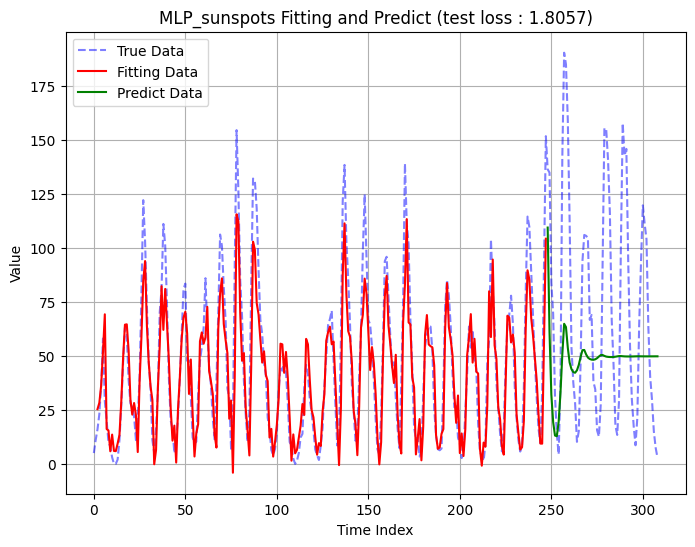

Model saved as model/MLP_sunspots.pth
--------------------------------------------------
Training BSplineKAN_sunspots model...


BSplineKAN_sunspots Epoch 50: 100%|█████████████████████| 50/50 [01:10<00:00,  1.40s/it, loss=0.1035, test_loss=2.6906]


Average Epoch Training Time :1.4003603649139404s


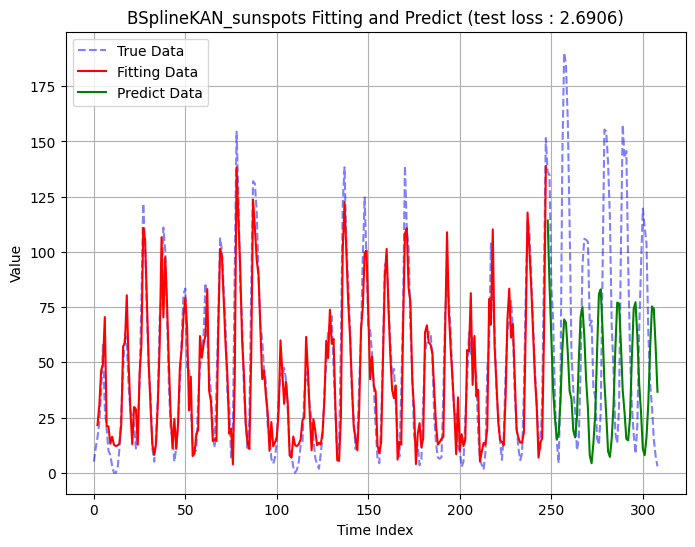

Model saved as model/BSplineKAN_sunspots.pth
--------------------------------------------------
Training FourierKAN_sunspots model...


FourierKAN_sunspots Epoch 50: 100%|█████████████████████| 50/50 [00:42<00:00,  1.18it/s, loss=0.0998, test_loss=2.3180]


Average Epoch Training Time :0.845434627532959s


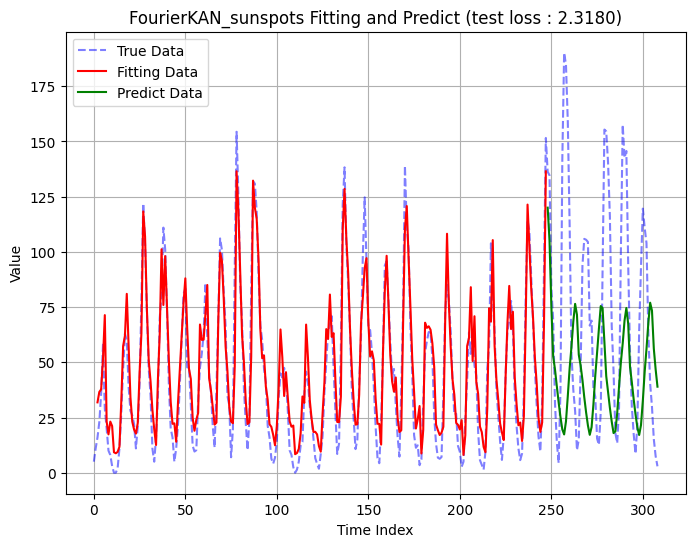

Model saved as model/FourierKAN_sunspots.pth
--------------------------------------------------
Training GaussianKAN_sunspots model...


GaussianKAN_sunspots Epoch 50: 100%|████████████████████| 50/50 [00:45<00:00,  1.11it/s, loss=0.0926, test_loss=1.4384]


Average Epoch Training Time :0.9044601678848266s


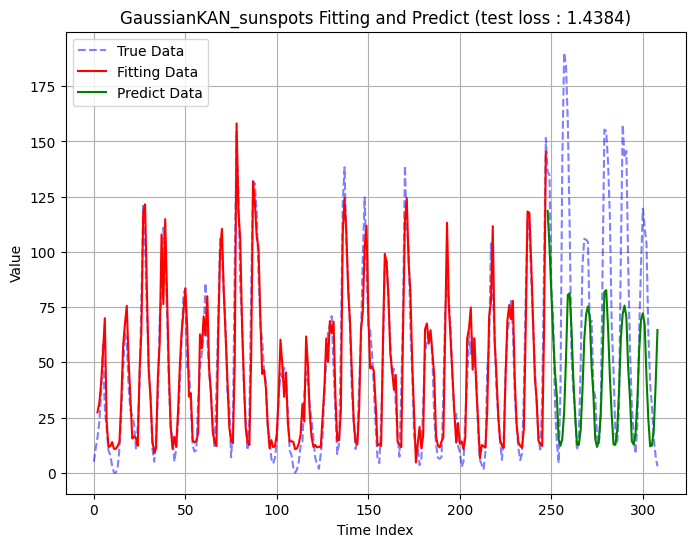

Model saved as model/GaussianKAN_sunspots.pth
--------------------------------------------------
Training JacobiKAN_sunspots model...


JacobiKAN_sunspots Epoch 50: 100%|██████████████████████| 50/50 [00:41<00:00,  1.20it/s, loss=0.0953, test_loss=1.1466]


Average Epoch Training Time :0.8349278831481933s


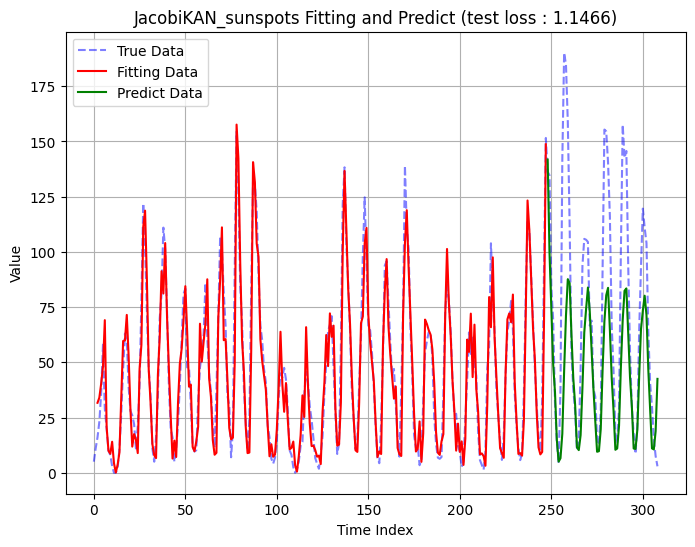

Model saved as model/JacobiKAN_sunspots.pth
--------------------------------------------------
Training RationalKAN_sunspots model...


RationalKAN_sunspots Epoch 50: 100%|████████████████████| 50/50 [00:37<00:00,  1.34it/s, loss=0.1059, test_loss=2.7337]


Average Epoch Training Time :0.7486646938323974s


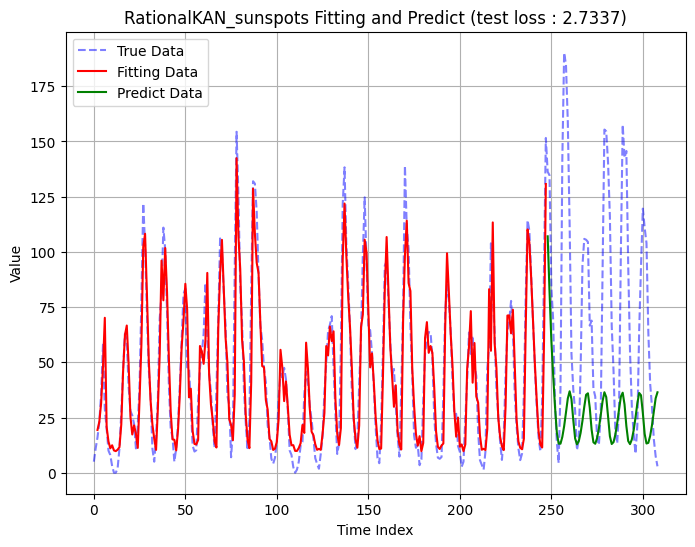

Model saved as model/RationalKAN_sunspots.pth
--------------------------------------------------
Training TaylorKAN_sunspots model...


TaylorKAN_sunspots Epoch 50: 100%|██████████████████████| 50/50 [00:28<00:00,  1.74it/s, loss=0.1027, test_loss=0.9278]


Average Epoch Training Time :0.5744106388092041s


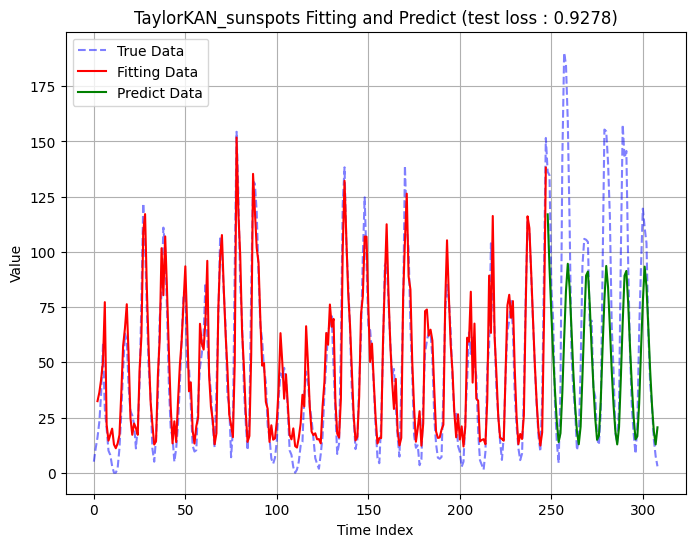

Model saved as model/TaylorKAN_sunspots.pth
--------------------------------------------------
Training WaveletKAN_sunspots model...


WaveletKAN_sunspots Epoch 50: 100%|█████████████████████| 50/50 [00:47<00:00,  1.06it/s, loss=0.1587, test_loss=2.2245]


Average Epoch Training Time :0.9428351736068725s


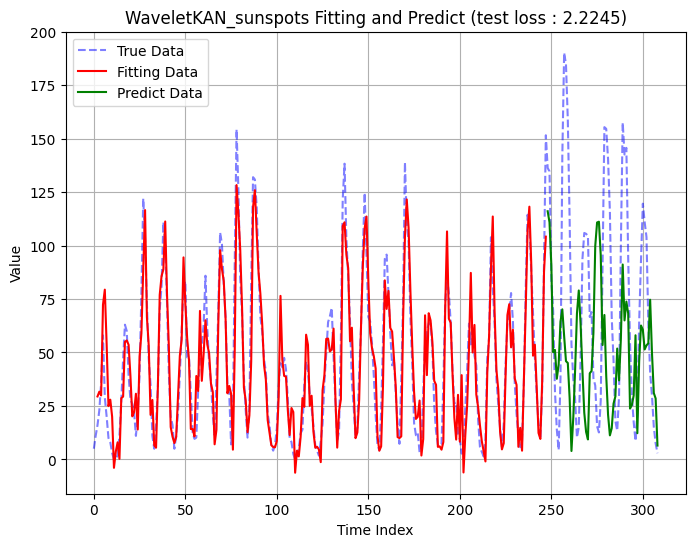

Model saved as model/WaveletKAN_sunspots.pth
--------------------------------------------------
Training BernsteinKAN_sunspots model...


BernsteinKAN_sunspots Epoch 50: 100%|███████████████████| 50/50 [00:49<00:00,  1.02it/s, loss=0.1022, test_loss=1.6025]


Average Epoch Training Time :0.9807021760940552s


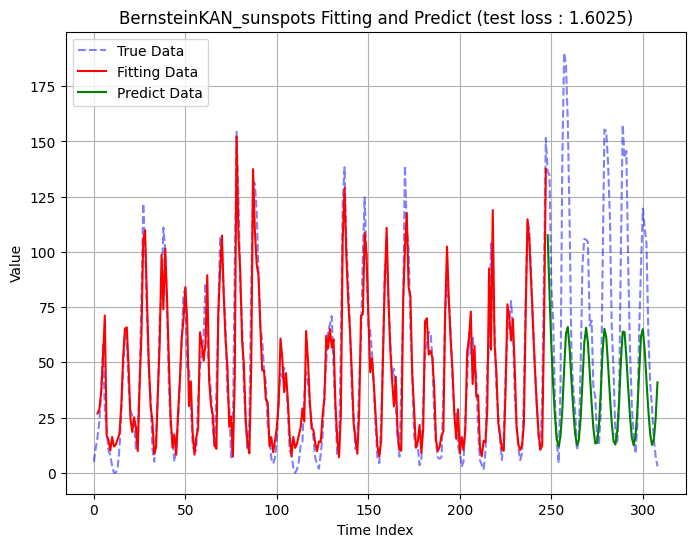

Model saved as model/BernsteinKAN_sunspots.pth


In [4]:
# Training
# mlp
model = MLP(layer_sizes, p_num).to(device)
mlp_epoch_losses, mlp_test_losses, mlp_epoch_time = train(model, series, 'MLP_sunspots', test_ratio, history_size, batch_size, num_epochs, save, criterion)
del model
torch.cuda.empty_cache()

# b_kan
model = BSplineKAN(layer_sizes, b_order, b_grid_range, b_grid_count).to(device)
b_epoch_losses, b_test_losses, b_epoch_time = train(model, series, 'BSplineKAN_sunspots', test_ratio, history_size, batch_size, num_epochs, save, criterion)
del model
torch.cuda.empty_cache()

# f_kan
model = FourierKAN(layer_sizes, frequency_count).to(device)
f_epoch_losses, f_test_losses, f_epoch_time = train(model, series, 'FourierKAN_sunspots', test_ratio, history_size, batch_size, num_epochs, save, criterion)
del model
torch.cuda.empty_cache()

# g_kan
model = GaussianKAN(layer_sizes, g_grid_range, g_grid_count).to(device)
g_epoch_losses, g_test_losses, g_epoch_time = train(model, series, 'GaussianKAN_sunspots', test_ratio, history_size, batch_size, num_epochs, save, criterion)
del model
torch.cuda.empty_cache()

# j_kan
model = JacobiKAN(layer_sizes, j_order, alpha, beta).to(device)
j_epoch_losses, j_test_losses, j_epoch_time = train(model, series, 'JacobiKAN_sunspots', test_ratio, history_size, batch_size, num_epochs, save, criterion)
del model
torch.cuda.empty_cache()

# r_kan
model = RationalKAN(layer_sizes, mole_order, deno_order).to(device)
r_epoch_losses, r_test_losses, r_epoch_time = train(model, series, 'RationalKAN_sunspots', test_ratio, history_size, batch_size, num_epochs, save, criterion)
del model
torch.cuda.empty_cache()

# t_kan
model = TaylorKAN(layer_sizes, t_order).to(device)
t_epoch_losses, t_test_losses, t_epoch_time = train(model, series, 'TaylorKAN_sunspots', test_ratio, history_size, batch_size, num_epochs, save, criterion)
del model
torch.cuda.empty_cache()

# w_kan
model = WaveletKAN(layer_sizes, wave_num, wave_type).to(device)
w_epoch_losses, w_test_losses, w_epoch_time = train(model, series, 'WaveletKAN_sunspots', test_ratio, history_size, batch_size, num_epochs, save, criterion)
del model
torch.cuda.empty_cache()

# be_kan
model = BernsteinKAN(layer_sizes, be_order, inter_range).to(device)
be_epoch_losses, be_test_losses, be_epoch_time = train(model, series, 'BernsteinKAN_sunspots', test_ratio, history_size, batch_size, num_epochs, save, criterion)
del model
torch.cuda.empty_cache()

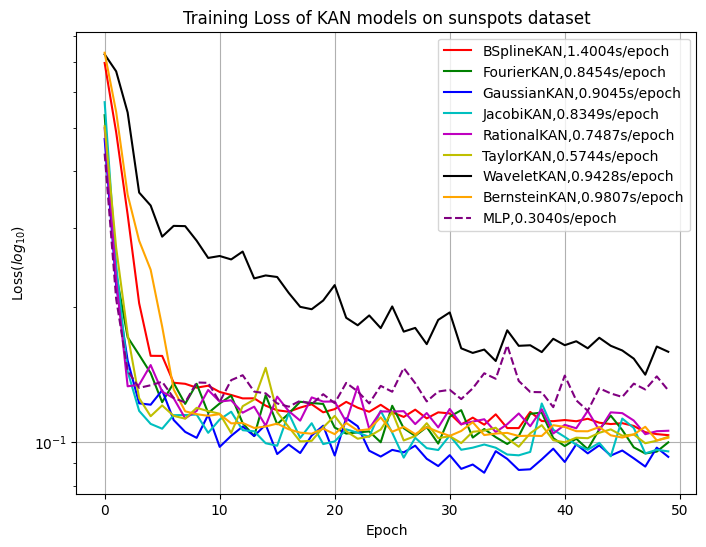

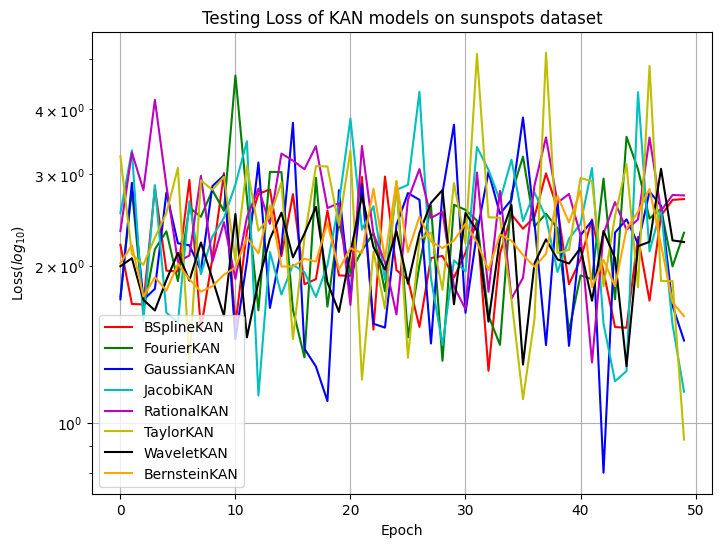

In [6]:
# Plot the loss curve
plt.figure(figsize=(8,6))
plt.plot(b_epoch_losses, label=f'BSplineKAN,{b_epoch_time:.4f}s/epoch', color='r')
plt.plot(f_epoch_losses, label=f'FourierKAN,{f_epoch_time:.4f}s/epoch', color='g')
plt.plot(g_epoch_losses, label=f'GaussianKAN,{g_epoch_time:.4f}s/epoch', color='b')
plt.plot(j_epoch_losses, label=f'JacobiKAN,{j_epoch_time:.4f}s/epoch', color='c')
plt.plot(r_epoch_losses, label=f'RationalKAN,{r_epoch_time:.4f}s/epoch', color='m')
plt.plot(t_epoch_losses, label=f'TaylorKAN,{t_epoch_time:.4f}s/epoch', color='y')
plt.plot(w_epoch_losses, label=f'WaveletKAN,{w_epoch_time:.4f}s/epoch', color='k')
plt.plot(be_epoch_losses, label=f'BernsteinKAN,{be_epoch_time:.4f}s/epoch', color='orange')
plt.plot(mlp_epoch_losses, label=f'MLP,{mlp_epoch_time:.4f}s/epoch', color='purple', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('Loss($log_{10}$)')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.title('Training Loss of KAN models on sunspots dataset')
plt.show()

# Plot the test loss curve
plt.figure(figsize=(8,6))
plt.plot(b_test_losses, label=f'BSplineKAN', color='r')
plt.plot(f_test_losses, label=f'FourierKAN', color='g')
plt.plot(g_test_losses, label=f'GaussianKAN', color='b')
plt.plot(j_test_losses, label=f'JacobiKAN', color='c')
plt.plot(r_test_losses, label=f'RationalKAN', color='m')
plt.plot(t_test_losses, label=f'TaylorKAN', color='y')
plt.plot(w_test_losses, label=f'WaveletKAN', color='k')
plt.plot(be_test_losses, label=f'BernsteinKAN', color='orange')
# plt.plot(mlp_test_losses, label=f'MLP', color='purple', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('Loss($log_{10}$)')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.title('Testing Loss of KAN models on sunspots dataset')
plt.show()